In [1]:
!pip install torch torchvision

#this notebook works—takes pretrained model, extract features on train then validation.
#then, uses these train features to train kmeans, and then predict on the validation features
#train on train -> predict on valid makes it worse
#train/predict on valid makes it better (this is not valid but technically this should mean our features are valid, right?)
#train on train + valid, predict on valid. exactly the same as train/predict on valid, perhpas meaning train on train is useless
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-02-26 20:26:00--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip’

train-images.zip    100%[===================>]  49.96M  9.19MB/s    in 6.6s    

2025-02-26 20:26:08 (7.52 MB/s) - ‘train-images.zip’ saved [52391647/52391647]

--2025-02-26 20:26:08--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip’

test-images.zip     100%[===================>]  12.21M  5.31MB/s    in 2.3s    

2025-02-26 20:26:12 (5.31 

In [3]:
!unzip train-images.zip
!unzip test-images.zip

Archive:  train-images.zip
   creating: train-images/
  inflating: train-images/348.png    
  inflating: train-images/1804.png   
 extracting: train-images/1810.png   
 extracting: train-images/1186.png   
 extracting: train-images/412.png    
 extracting: train-images/374.png    
  inflating: train-images/1838.png   
 extracting: train-images/360.png    
 extracting: train-images/406.png    
  inflating: train-images/1192.png   
 extracting: train-images/1179.png   
 extracting: train-images/1145.png   
 extracting: train-images/1623.png   
 extracting: train-images/1637.png   
 extracting: train-images/1151.png   
 extracting: train-images/638.png    
  inflating: train-images/176.png    
 extracting: train-images/88.png     
 extracting: train-images/610.png    
 extracting: train-images/1384.png   
 extracting: train-images/1390.png   
 extracting: train-images/604.png    
  inflating: train-images/162.png    
 extracting: train-images/189.png    
 extracting: train-images/837.png 

# Handling the data

In [4]:
# # Load the train labels
# # Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [5]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [6]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
# data_test = load_dataset(data_dir / "test-images")

# labeled_train_data = data_train[:800]
unlabeled_train_data = data_train[800:]
# labeled_train_labels = labels_train[:800]
unlabeled_train_labels = labels_train[800:]

In [7]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [8]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
# plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((256,256)))

# Let's compute a baseline

In [9]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

In [10]:
# Let's display the results
# Not too bad!
# plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [11]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [12]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [13]:
# Compute baseline on a few train data
# labels_val_predicted_baseline = compute_baseline(data_val)

In [14]:
NUM_CLASSES = 54 # 55 classes in total, but the first one is the background


def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))


In [15]:
# Compute the metric on the validation set
# dice_pandas(labels_val, labels_val_predicted_baseline)
# We get => (0.0011196021617737601); Not so bad, but room for improvements!
# Let's see if you can do better!

SyntaxError: unterminated string literal (detected at line 4) (<ipython-input-15-2d29e8000109>, line 4)

In [16]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [17]:


# Define preprocessing transforms
transform = T.Compose([
    T.Resize(224),  # Resize to DINOv2 expected input size
    T.ToTensor(),  # Convert to tensor
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])  # Normalize
])
# transform = T.Compose([
#     T.Resize(224),
#     T.CenterCrop(224),
#     T.ToTensor(),
#     T.Normalize(mean=[0.5], std=[0.5]),
# ])

def preprocess_image(image_array):
    """
    Convert grayscale (256x256) CT scan to a format usable by DINOv2.
    - image_array: NumPy array of shape (256, 256), values in range [0,1].
    - Returns: Tensor of shape (3, 224, 224) ready for DINOv2.
    """
    img = np.stack([image_array] * 3, axis=-1)  # Convert grayscale (H,W) → RGB (H,W,3)
    img = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image
    img = transform(img)  # Apply resizing and normalization
    return img

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')


In [31]:



import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Custom dataset class for multiple grayscale CT scans
class CTDataset(Dataset):
    def __init__(self, images):
        """
        images: A list or NumPy array of shape (N, 256, 256) containing grayscale CT scans.
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Get (256, 256) image
        #return img
        return preprocess_image(img)  # Convert to 3-channel 224x224 tensor

# # Load dataset (replace `ct_scan_data` with your actual dataset)
train_dataset = CTDataset(unlabeled_train_data)  # `ct_scan_data` should be (N, 256, 256)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=4)

valid_dataset = CTDataset(data_val)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)

all_dataset = CTDataset(data_train)
all_dataloader = DataLoader(all_dataset, batch_size=8, shuffle=False, num_workers=4)
# # Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Extract features for all images
# train_patch_features_list = []
# train_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(train_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         #print(features_dict)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         train_patch_features_list.append(patch_features)
#         train_cls_features_list.append(cls_features)
#         #train_features_list.append(features.cpu().numpy())

# valid_patch_features_list = []
# valid_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(valid_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         valid_patch_features_list.append(patch_features)
#         valid_cls_features_list.append(cls_features)


all_patch_features_list = []
all_cls_features_list = []
with torch.no_grad():
    for batch in tqdm(all_dataloader):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        cls_features = features_dict["x_norm_clstoken"]  # Patch features
        all_patch_features_list.append(patch_features)
        all_cls_features_list.append(cls_features)



# Reduce dimensionality with PCA (for visualization)
#patch_features = torch.cat(train_patch_features_list, dim=0)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 250/250 [10:27<00:00,  2.51s/it]


torch.Size([8, 256, 384])


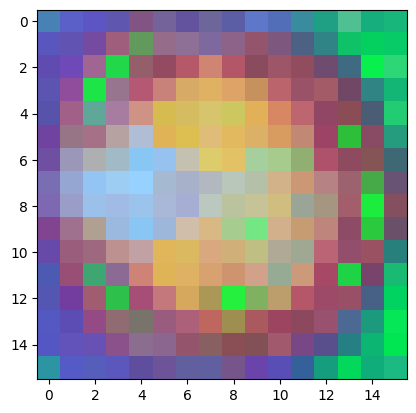

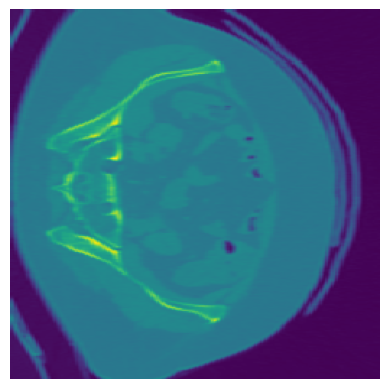

In [58]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
print(all_patch_features_list[0].shape)
patch_features = all_patch_features_list[0][1]
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_features.squeeze(0).cpu().numpy())

# Normalize PCA features for visualization
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = (pca_features * 255).astype(np.uint8)

# Visualize the extracted features as an image
plt.imshow(pca_features.reshape(16, 16, 3))
plt.show()
plt.axis("off")
plt.savefig('meta_dog_features.png')
plt.imshow(data_train[0])


#finetuning for model on our unlabeled data... work in progress
# teacher_model = AutoModel.from_pretrained('facebook/dinov2-large')
# student_model = AutoModel.from_pretrained('facebook/dinov2-large')
# teacher_model = AutoModel.from_pretrained('facebook/dinov2-base')
# student_model = AutoModel.from_pretrained('facebook/dinov2-base')
# optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-6, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# teacher_model.to(device)
# student_model.to(device)
# scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision
# # Disable gradients for the teacher model
# for param in teacher_model.parameters():
#     param.requires_grad = False
def tensor_to_pil(tensor):
    """Convert a single torch.Tensor image to PIL Image."""
    return transforms.ToPILImage()(tensor.cpu())

def augment_tensor(batch):
    """Applies random augmentations directly to a batch of images."""
    batch = F.resize(batch, (224, 224))  # Resize the whole batch at once

    if torch.rand(1) < 0.5:
        batch = F.hflip(batch)  # Random horizontal flip

    if torch.rand(1) < 0.2:
        batch = F.gaussian_blur(batch, kernel_size=(3, 3))  # Random blur

    return batch

def update_teacher(student_model, teacher_model, momentum=0.996):
    """Updates teacher model weights using EMA of student model weights."""
    for student_param, teacher_param in zip(student_model.parameters(), teacher_model.parameters()):
        teacher_param.data = momentum * teacher_param.data + (1 - momentum) * student_param.data

def dino_loss(student_output, teacher_output, temperature=0.5):
    """Computes contrastive loss between student and teacher outputs."""
    student_features = student_output.last_hidden_state  # Extract tensor

    # ✅ Fix: Center logits before applying softmax
    student_features = student_features - student_features.max(dim=-1, keepdim=True)[0]
    teacher_features = teacher_output - teacher_output.max(dim=-1, keepdim=True)[0]
    # Compute L2 distance between student and teacher features
    diff = torch.norm(student_features - teacher_features, dim=-1)
    print("Feature Difference Norm:", diff.mean().item())
    # Compute softmax
    student_probs = torch.nn.functional.softmax(student_features / temperature, dim=-1)
    teacher_probs = torch.nn.functional.softmax(teacher_features / temperature, dim=-1)
    print("Student Probs Min:", student_probs.min().item(), "Max:", student_probs.max().item())
    print("Teacher Probs Min:", teacher_probs.min().item(), "Max:", teacher_probs.max().item())

    # student_probs = torch.nn.functional.softmax(student_features / temperature, dim=-1)
    # teacher_probs = torch.nn.functional.softmax(teacher_output / temperature, dim=-1)



    return -torch.mean(torch.sum(teacher_probs * torch.log(student_probs), dim=-1))

# num_epochs = 20  # Number of fine-tuning epochs
# student_model.train()
# teacher_model.eval()  # Teacher is frozen

# for epoch in range(num_epochs):
#     total_loss = 0.0
#     progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

#     for batch in progress_bar:
#         batch = batch.to(device)
#         with torch.cuda.amp.autocast():

#           # Generate two different augmentations of the same image
#           view_1 = augment_tensor(batch)

#           view_2 = augment_tensor(batch)

#           # Forward pass (Student)
#           student_out_1 = student_model(view_1)
#           student_out_2 = student_model(view_2)

#           # Forward pass (Teacher) - No gradients
#           with torch.no_grad():
#               teacher_out_1 = teacher_model(view_1).last_hidden_state.detach()
#               teacher_out_2 = teacher_model(view_2).last_hidden_state.detach()

#           # Compute DINO loss
#           if torch.isnan(student_out_1.last_hidden_state).any():
#               print("Student output contains NaN!")
#           if torch.isnan(student_out_2.last_hidden_state).any():
#               print("Student output contains NaN!")

#           if torch.isnan(teacher_out_1).any():
#               print("Teacher output contains NaN!")
#           if torch.isnan(teacher_out_2).any():
#               print("Teacher output contains NaN!")
#           loss = (dino_loss(student_out_1, teacher_out_1) + dino_loss(student_out_2, teacher_out_2)) / 2
#           scaler.scale(loss).backward()
#           scaler.step(optimizer)
#           scaler.update()
#           # Backpropagation
#           # optimizer.zero_grad()
#           # loss.backward()
#           # optimizer.step()
#           scheduler.step()



#           # Update teacher model using EMA
#           update_teacher(student_model, teacher_model, momentum=0.996)

#           for name, param in student_model.named_parameters():
#             if param.grad is not None:
#                 print(f"{name} Grad Norm: {param.grad.norm().item()}")

#           total_loss += loss.item()
#           progress_bar.set_postfix({"Loss": loss.item()})

#     print(f"Epoch {epoch+1} Loss: {total_loss / len(train_dataloader)}")

# print("Finished fine-tuning DINOv2!")

# # import numpy as np

# # # Get mean & std across patches (excluding CLS token)
# # features_no_cls = all_features[:, :-1, :]  # Remove CLS token (shape: 128, 256, 1024)

# # print("Feature Mean:", np.mean(features_no_cls))
# # print("Feature Std:", np.std(features_no_cls))


torch.Size([2000, 256, 384])
torch.Size([2000, 384])
250


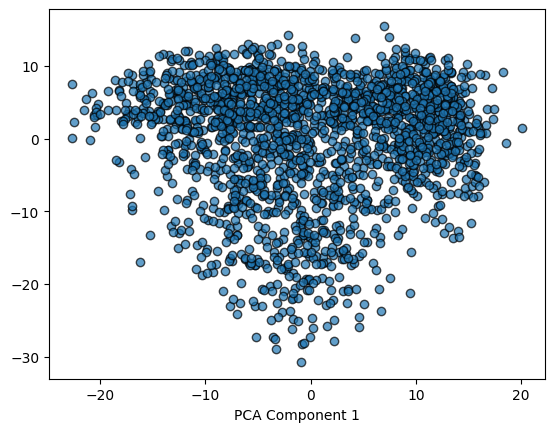

In [56]:
#train and validation features are here
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
patch_features = torch.cat(all_patch_features_list, dim=0)
# cls_features = torch.cat(train_cls_features_list, dim=0)
cls_features = torch.cat(all_cls_features_list, dim=0)
print(patch_features.shape)
print(cls_features.shape)

print(len(all_cls_features_list))
# Assuming cls_features is a tensor of shape (num_images, 384)
cls_features_np = cls_features.cpu().numpy()  # Convert to NumPy

# Reduce 384D CLS features to 2D
pca = PCA(n_components=2)
cls_2d = pca.fit_transform(cls_features_np)

# Scatter plot
plt.scatter(cls_2d[:, 0], cls_2d[:, 1], alpha=0.7, edgecolors="k")
plt.xlabel("PCA Component 1")
plt.show()
# print(plt.imshow(data_train[1]))
# print(type(all_patch_features_list[0]))
# import torch

#tensor_list = [torch.randn(3, 3), torch.ones(5, 5), torch.zeros(2, 2)]  # Example tensor list
torch.save(all_patch_features_list, "all_patch_features.pth")  # Save to a file
torch.save(cls_features, "all_cls_features.pth")
# train_features = np.concatenate(train_features_list, axis=0)
# valid_features = np.concatenate(valid_features_list, axis=0)
# print("LABELS VAL SHAPE")
# print(labels_val.shape)
# print("TRAIN FEATURES SHAPE")
# print(train_features.shape)
# print("VALID FEATURES SHAPE")
# print(valid_features.shape)
# train_features_reshape = train_features.reshape(train_features.shape[0], -1)
# valid_features_reshape = valid_features.reshape(valid_features.shape[0], -1)
# print("TRAIN FEATURES RESHAPE SHAPE")
# print(train_features_reshape.shape)
# print("VALID FEATURES RESHAPE SHAPE")
# print(valid_features_reshape.shape)

In [22]:
#proof of concept, using GMM / Kmeans to see if features help prediction, then compare to baseline.
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# **1️⃣ Remove CLS Token** (Keeping only image patches)
train_features_patches = train_features[:, 1:, :]  # (200, 256, 768)
valid_features_patches = valid_features[:, 1:, :]  # (200, 256, 768)

# **2️⃣ Reshape for PCA & Clustering**
train_features_reshaped = train_features_patches.reshape(-1, 768)  # (51200, 768)
valid_features_reshaped = valid_features_patches.reshape(-1, 768)  # (51200, 768)

# **3️⃣ Apply PCA to Preserve 99% Variance**
pca = PCA(n_components=0.99, random_state=42)  # Automatically keeps 99% variance
train_features_pca = pca.fit_transform(train_features_reshaped)
valid_features_pca = pca.transform(valid_features_reshaped)

print(f"✅ PCA Applied - New Feature Shape: {train_features_pca.shape}")  # Should be smaller than (51200, 768)

# **4️⃣ GMM Clustering on PCA-Reduced Features**
num_clusters = NUM_CLASSES  # Same number as K-Means

#running GMM takes a very long time
#gmm = GaussianMixture(n_components=num_clusters, random_state=42)

# Train GMM on PCA-reduced DINOv2 features
gmm.fit(train_features_pca)

# Predict clusters for validation set
cluster_labels = gmm.predict(valid_features_pca)

print("✅ GMM Clustering Complete - Cluster Labels Shape:", cluster_labels.shape)


#Kmeans here
# import numpy as np
# from sklearn.cluster import KMeans
# train_features_patches = train_features[:, 1:, :]  # (200, 256, 768)
# valid_features_patches = valid_features[:, 1:, :]  # (200, 256, 768)

# # **3️⃣ Reshape for Clustering**
# train_features_reshaped = train_features_patches.reshape(-1, 768)  # (51200, 768)
# valid_features_reshaped = valid_features_patches.reshape(-1, 768)  # (51200, 768)

# # **4️⃣ K-Means Clustering**
# # num_clusters = NUM_CLASSES
# # kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# # kmeans.fit(train_features_reshaped)
# # cluster_labels = kmeans.predict(valid_features_reshaped)



# # Predict clusters for validation images
# #cluster_labels = kmeans.predict(valid_features_reshaped)
# # kmeans2 = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# # cluster_labels2 = kmeans2.fit_predict(valid_features_reshaped)  # (51200,)




✅ PCA Applied - New Feature Shape: (307200, 651)
✅ GMM Clustering Complete - Cluster Labels Shape: (51200,)


In [24]:
# import numpy as np
# Compute Dice Score for DINO + K-Means segmentation
import torch.nn.functional as F
segmented_images = cluster_labels.reshape(200, 16, 16)  # (200, 16, 16)
# **6️⃣ Upsample to (200, 256, 256)**
segmented_images_tensor = torch.tensor(segmented_images).float().unsqueeze(1)  # (200, 1, 16, 16)
segmented_images_resized = F.interpolate(segmented_images_tensor, size=(256, 256), mode="nearest")  # (200, 1, 256, 256)
segmented_images_resized = segmented_images_resized.squeeze(1).numpy()  # Convert back to NumPy

# **7️⃣ Flatten to (200, 65536)**
segmented_images_flattened = segmented_images_resized.reshape(200, 65536)  # ✅ Final Shape

print("Final Segmented Labels Shape:", segmented_images_flattened.shape)  # Should be (200, 65536)


# segmented_images_resized = F.interpolate(segmented_images_tensor, size=(256, 256), mode="nearest")  # (200, 1, 256, 256)
# segmented_images_resized = segmented_images_resized.squeeze(1).numpy()  # Convert back to NumPy

# # **7️⃣ Flatten to (200, 65536)**
# segmented_images_flattened = segmented_images_resized.reshape(200, 65536)  # ✅ Final Shape

# print("Final Segmented Labels Shape:", segmented_images_flattened.shape)  # Should be (200, 65536)
# segmented_images_resized = F.interpolate(segmented_images_tensor, size=(256, 256), mode="nearest")
labels_val_predicted_dino_kmeans = pd.DataFrame(segmented_images_flattened)
dice_dino_kmeans = dice_pandas(labels_val, labels_val_predicted_dino_kmeans)
print("DINO + K-Means Dice Score:", dice_dino_kmeans)

# # Remove CLS token (keeps only 256 patch features per image)
# features_no_cls = all_features[:, :-1, :]  # Shape: (128, 256, 1024)

# # Reshape: each row is a patch's 1024D feature vector
# reshaped_features = features_no_cls.reshape(-1, 1024)  # Shape: (128 * 256, 1024)

# print("K-Means Input Shape:", reshaped_features.shape)  # Expected: (total_patches, feature_dim)


Final Segmented Labels Shape: (200, 65536)
DINO + K-Means Dice Score: 0.000471539058616463


<ipython-input-14-026daa8c8e93>:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)
